Azure ML & Azure Databricks notebooks by Parashar Shah.

Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# AutoML : Classification with Local Compute on Azure DataBricks

In this example we use the scikit-learn's [digit dataset](http://scikit-learn.org/stable/datasets/index.html#optical-recognition-of-handwritten-digits-dataset) to showcase how you can use AutoML for a simple classification problem.

In this notebook you will learn how to:
1. Create Azure Machine Learning Workspace object and initialize your notebook directory to easily reload this object from a configuration file.
2. Create an `Experiment` in an existing `Workspace`.
3. Configure AutoML using `AutoMLConfig`.
4. Train the model using Azure Databricks.
5. Explore the results.
6. Test the best fitted model.

#Before running this notebook, please follow the readme for installing necessary libraries to your cluster.

## Register Machine Learning Services Resource Provider
Microsoft.MachineLearningServices only needs to be registed once in the subscription. To register it:
Start the Azure portal.
Select your All services and then Subscription.
Select the subscription that you want to use.
Click on Resource providers
Click the Register link next to Microsoft.MachineLearningServices

### Check the Azure ML Core SDK Version to Validate Your Installation

In [5]:
import azureml.core

print("SDK Version:", azureml.core.VERSION)

SDK Version: 1.0.6

## Initialize an Azure ML Workspace
### What is an Azure ML Workspace and Why Do I Need One?

An Azure ML workspace is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows.  In particular, an Azure ML workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, operationalization, and the monitoring of operationalized models.


### What do I Need?

To create or access an Azure ML workspace, you will need to import the Azure ML library and specify following information:
* A name for your workspace. You can choose one.
* Your subscription id. Use the `id` value from the `az account show` command output above.
* The resource group name. The resource group organizes Azure resources and provides a default region for the resources in the group. The resource group will be created if it doesn't exist. Resource groups can be created and viewed in the [Azure portal](https://portal.azure.com)
* Supported regions include `eastus2`, `eastus`,`westcentralus`, `southeastasia`, `westeurope`, `australiaeast`, `westus2`, `southcentralus`.

In [7]:
#subscription_id = "<Your SubscriptionId>" #you should be owner or contributor
#resource_group = "<Resource group - new or existing>" #you should be owner or contributor
#workspace_name = "<workspace to be created>" #your workspace name
#workspace_region = "<azureregion>" #your region

## Creating a Workspace
If you already have access to an Azure ML workspace you want to use, you can skip this cell.  Otherwise, this cell will create an Azure ML workspace for you in the specified subscription, provided you have the correct permissions for the given `subscription_id`.

This will fail when:
1. The workspace already exists.
2. You do not have permission to create a workspace in the resource group.
3. You are not a subscription owner or contributor and no Azure ML workspaces have ever been created in this subscription.

If workspace creation fails for any reason other than already existing, please work with your IT administrator to provide you with the appropriate permissions or to provision the required resources.

**Note:** Creation of a new workspace can take several minutes.

In [9]:
# Import the Workspace class and check the Azure ML SDK version.#
#from azureml.core import Workspace

#ws = Workspace.create(name = workspace_name,
#                      subscription_id = subscription_id,
#                      resource_group = resource_group, 
#                      location = workspace_region,
#                      exist_ok=True)
#ws.get_details()

## Configuring Your Local Environment
You can validate that you have access to the specified workspace and write a configuration file to the default configuration location, `./aml_config/config.json`.

In [11]:
#from azureml.core import Workspace

#ws = Workspace(workspace_name = workspace_name,
#               subscription_id = subscription_id,
#               resource_group = resource_group)

# Persist the subscription id, resource group name, and workspace name in aml_config/config.json.
#ws.write_config()

## Create an Experiment

As part of the setup you have already created an Azure ML `Workspace` object. For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [13]:
import logging
import os
import random
import time

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

In [14]:
ws = Workspace.from_config()

# Choose a name for the experiment and specify the project folder.
experiment_name = 'automl-local-classification'
project_folder = './sample_projects/automl-local-classification'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

Found the config file in: /databricks/driver/aml_config/config.json
 Out[ 9 ]: 
 
Experiment Name automl-local-classification 
Location westeurope 
Project Directory ./sample_projects/automl-local-classification
Resource Group resgrpAMLS 
SDK version 1.0.6 
Subscription ID 70b8f39e-8863-49f7-b6ba-34a80799550c 
Workspace Name AMLSworkspace

## Diagnostics

Opt-in diagnostics for better experience, quality, and security of future releases.

In [16]:
from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics = True)

Turning diagnostics collection on.

## Load Training Data Using DataPrep

In [18]:
import azureml.dataprep as dprep
# You can use `auto_read_file` which intelligently figures out delimiters and datatypes of a file.
# The data referenced here was pulled from `sklearn.datasets.load_digits()`.
simple_example_data_root = 'https://dprepdata.blob.core.windows.net/automl-notebook-data/'
X_train = dprep.auto_read_file(simple_example_data_root + 'X.csv').skip(1)  # Remove the header row.

# You can also use `read_csv` and `to_*` transformations to read (with overridable delimiter)
# and convert column types manually.
# Here we read a comma delimited file and convert all columns to integers.
y_train = dprep.read_csv(simple_example_data_root + 'y.csv').to_long(dprep.ColumnSelector(term='.*', use_regex = True))

## Review the Data Preparation Result
You can peek the result of a Dataflow at any range using skip(i) and head(j). Doing so evaluates only j records for all the steps in the Dataflow, which makes it fast even against large datasets.

In [20]:
X_train.skip(1).head(10)

Out[ 12 ]: 
 Column1 Column2 Column3 ... Column62 Column63 Column64
0 0.0 0.0 0.0 ... 10.0 0.0 0.0 
1 0.0 0.0 0.0 ... 16.0 9.0 0.0 
2 0.0 0.0 7.0 ... 9.0 0.0 0.0 
3 0.0 0.0 0.0 ... 4.0 0.0 0.0 
4 0.0 0.0 12.0 ... 10.0 0.0 0.0 
5 0.0 0.0 0.0 ... 11.0 3.0 0.0 
6 0.0 0.0 7.0 ... 0.0 0.0 0.0 
7 0.0 0.0 9.0 ... 11.0 1.0 0.0 
8 0.0 0.0 11.0 ... 3.0 0.0 0.0 
9 0.0 0.0 1.0 ... 3.0 0.0 0.0 

[10 rows x 64 columns]

## Configure AutoML

Instantiate an `AutoMLConfig` object to specify the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**primary_metric**|This is the metric that you want to optimize. Regression supports the following primary metrics: <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**iterations**|Number of iterations. In each iteration AutoML trains a specific pipeline with the data.|
|**n_cross_validations**|Number of cross validation splits.|
|**spark_context**|Spark Context object. for Databricks, use spark_context=sc|
|**max_concurrent_iterations**|Maximum number of iterations to execute in parallel. This should be <= number of worker nodes in your Azure Databricks cluster.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], [n_samples, n_classes]<br>Multi-class targets. An indicator matrix turns on multilabel classification. This should be an array of integers.|
|**path**|Relative path to the project folder. AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder.|
|**exit_score**|Target score for your experiment. It is associated with the metric.|

In [22]:
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             primary_metric = 'AUC_weighted',
                             iteration_timeout_minutes = 10,
                             iterations = 10,
                             n_cross_validations = 5,
                             max_concurrent_iterations = 2, #change it based on number of worker nodes
                             verbosity = logging.INFO,
                             spark_context=sc, #databricks/spark related
                             X = X_train, 
                             y = y_train,
                             path = project_folder)

## Train the Models

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console. If you are running a lot of iterations, you can set it to False and visualize in the portal.

In [24]:
local_run = experiment.submit(automl_config, show_output = True)

Running on ADB cluster experiment automl-local-classification.
Parent Run ID: AutoML_1fbc3370-1c81-40fc-9e8c-ef2365b540f1
*******************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
TRAINFRAC: Fraction of the training data to train on.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
*******************************************************************************************************

 ITERATION PIPELINE TRAINFRAC DURATION METRIC BEST
 1 MaxAbsScaler LogisticRegression 1 0:00:14 0.9993 0.9993
 0 StandardScalerWrapper KNN 1 0:00:20 0.9982 0.9993
 2 StandardScalerWrapper KNN 1 0:00:12 0.9989 0.9993
 3 MaxAbsScaler LightGBM 1 0:00:10 0.9968 0.9993
 4 StandardScalerWrapper LightGBM 1 0:00:09 0.9931 0.9993
 5 StandardScalerWrapper LogisticRegression 1 0:00:13 0.9950 0.9993
 6 SparseNormalizer LightGBM 1 0:00:13 0.9969 0.9993
 7 RobustScaler ExtremeRandomTrees 1 0:00:10 0.9948 0.9993
 8 TruncatedSVDWrapper KNN 1 0:00:09 0.9990 0.9993
 9 StandardScalerWrapper LightGBM 1 0:00:21 0.9992 0.9993

## Explore the Results

#### Portal URL for Monitoring Runs

The following will provide a link to the web interface to explore individual run details and status.

In [27]:
print(local_run.get_portal_url())

https://mlworkspace.azure.ai/portal/subscriptions/70b8f39e-8863-49f7-b6ba-34a80799550c/resourceGroups/resgrpAMLS/providers/Microsoft.MachineLearningServices/workspaces/AMLSworkspace/experiments/automl-local-classification/runs/AutoML_1fbc3370-1c81-40fc-9e8c-ef2365b540f1

#### Retrieve All Child Runs after the experiment has COMPLETED.
You can also use SDK methods to fetch all the child runs and see individual metrics that we log. This can take some time.

In [29]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}    
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

Out[ 16 ]: 
 0 ... 9
AUC_macro 0.998282 ... 0.999186
AUC_micro 0.998238 ... 0.999236
AUC_weighted 0.998175 ... 0.999216
AUC_weighted_max 0.998175 ... 0.999216
accuracy 0.972174 ... 0.967727
average_precision_score_macro 0.992272 ... 0.994016
average_precision_score_micro 0.991785 ... 0.994569
average_precision_score_weighted 0.991931 ... 0.994373
balanced_accuracy 0.972599 ... 0.967710
f1_score_macro 0.972135 ... 0.967508
f1_score_micro 0.972174 ... 0.967727
f1_score_weighted 0.972134 ... 0.967746
log_loss 0.186200 ... 0.178787
norm_macro_recall 0.969554 ... 0.964122
precision_score_macro 0.972859 ... 0.968382
precision_score_micro 0.972174 ... 0.967727
precision_score_weighted 0.973265 ... 0.968793
recall_score_macro 0.972599 ... 0.967710
recall_score_micro 0.972174 ... 0.967727
recall_score_weighted 0.972174 ... 0.967727
weighted_accuracy 0.971907 ... 0.967584

[21 rows x 10 columns]

### Retrieve the Best Model after the experiment has COMPLETED.

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [31]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: automl-local-classification,
Id: AutoML_1fbc3370-1c81-40fc-9e8c-ef2365b540f1_1,
Type: None,
Status: Completed)
Pipeline(memory=None,
 steps=[('MaxAbsScaler', MaxAbsScaler(copy=True)), ('LogisticRegression', LogisticRegression(C=2.559547922699533, class_weight='balanced', dual=False,
 fit_intercept=True, intercept_scaling=1, max_iter=100,
 multi_class='multinomial', n_jobs=1, penalty='l2',
 random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
 warm_start=False))])

#### Best Model Based on Any Other Metric after the above run is complete based on the child run
Show the run and the model that has the smallest `log_loss` value:

In [33]:
lookup_metric = "log_loss"
best_run, fitted_model = local_run.get_output(metric = lookup_metric)
print(best_run)
print(fitted_model)

Run(Experiment: automl-local-classification,
Id: AutoML_1fbc3370-1c81-40fc-9e8c-ef2365b540f1_1,
Type: None,
Status: Completed)
Pipeline(memory=None,
 steps=[('MaxAbsScaler', MaxAbsScaler(copy=True)), ('LogisticRegression', LogisticRegression(C=2.559547922699533, class_weight='balanced', dual=False,
 fit_intercept=True, intercept_scaling=1, max_iter=100,
 multi_class='multinomial', n_jobs=1, penalty='l2',
 random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
 warm_start=False))])

### Test the Best Fitted Model

#### Load Test Data - you can split the dataset beforehand & pass Train dataset to AutoML and use Test dataset to evaluate the best model.

In [35]:
from sklearn import datasets
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

#### Testing Our Best Fitted Model
We will try to predict digits and see how our model works. This is just an example to show you.

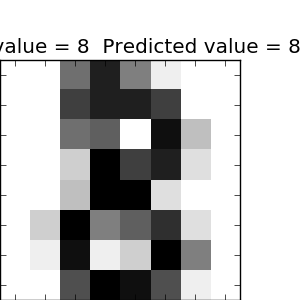

In [37]:
# Randomly select digits and test.

for index in np.random.choice(len(y_test), 2, replace = False):
    print(index)
    predicted = fitted_model.predict(X_test[index:index + 1])[0]
    label = y_test[index]
    title = "Label value = %d  Predicted value = %d " % (label, predicted)
    fig = plt.figure(1, figsize = (3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    display(fig)